In [1]:
BLACKHOLE = False


import os
import sys
from pathlib import Path
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # fixes problem with graph


if BLACKHOLE:
    workspace_path = os.path.expandvars('$BLACKHOLE')
    sys.path.append(workspace_path+'/DeepLearning/02456_news_project/src')
    DATAPATH = Path(workspace_path+"/DeepLearning/ebnerd_data").expanduser()
else:
    DATAPATH = Path("~/ebnerd_data").expanduser()

DATASET = "ebnerd_demo"
#DATASET = "ebnerd_small"
#DATASET = "ebnerd_large"

In [2]:
import torch

print("torch version:", torch.__version__)

# Check gpu availability


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Test:
#print(torch.zeros(1).cuda())

torch version: 2.5.1+cu124
cuda


In [3]:
from utils.data_handler import NewsDataset
import from_ebrec._constants as cs

SEED = 65
HISTORY_SIZE = 50

COLS = [
    cs.DEFAULT_USER_COL,
    cs.DEFAULT_IMPRESSION_ID_COL,
    cs.DEFAULT_IMPRESSION_TIMESTAMP_COL,
    cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    cs.DEFAULT_CLICKED_ARTICLES_COL,
    cs.DEFAULT_INVIEW_ARTICLES_COL,
]

#FRACTION = 0.001
FRACTION = 0.01
#FRACTION = 0.1
#FRACTION = 1

# test
dataset = NewsDataset()

dataset.setup_df(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED)


In [4]:
import transformers as huggingface
from from_ebrec._nlp import get_transformers_word_embeddings
from from_ebrec._polars import concat_str_columns
from from_ebrec._articles import convert_text2encoding_with_transformers
from from_ebrec._articles import create_article_id_to_value_mapping

dataset.setup_articles_data(dataset_path = DATAPATH.joinpath(DATASET))

df_articles = dataset.df_articles

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TEXT_COLUMNS_TO_USE = [cs.DEFAULT_SUBTITLE_COL, cs.DEFAULT_TITLE_COL, cs.DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = huggingface.AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = huggingface.AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

word2vec_embedding = get_transformers_word_embeddings(transformer_model)
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH)
article_mapping = create_article_id_to_value_mapping(df=df_articles, value_col=token_col_title)



In [5]:
from dataloader import NRMSDataLoader

BATCH_SIZE = 64

train_dataloader = NRMSDataLoader(
    behaviors= dataset.df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=BATCH_SIZE,
)
val_dataloader = NRMSDataLoader(
    behaviors= dataset.df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=BATCH_SIZE,
)


In [6]:
#print(train_dataloader)
#print(val_dataloader)

In [7]:
from nrms import NRMSModel
from hyperparameters import hparams_nrms

hparams = hparams_nrms()

# PARAMETERS
hparams.title_size = MAX_TITLE_LENGTH
hparams.history_size = HISTORY_SIZE

# MODEL ARCHITECTURE
hparams.head_num = 16
hparams.head_dim = 16
hparams.attention_hidden_dim = 1000
hparams.linear_hidden_dim = 200

hparams.use_positional_encoding = False
hparams.use_learned_positions = False

# MODEL OPTIMIZER:
hparams.optimizer = "adam"
hparams.loss = "mse_loss"
hparams.dropout = 0.2
hparams.learning_rate = 1e-4

model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding, debug=False)

print(model)


NRMSModel(
  (news_encoder): NewsEncoder(
    (embedding): Embedding(250002, 768)
    (dropout): Dropout(p=0.2, inplace=False)
    (self_attention): SelfAttention(
      (query_proj): Linear(in_features=768, out_features=256, bias=True)
      (key_proj): Linear(in_features=768, out_features=256, bias=True)
      (value_proj): Linear(in_features=768, out_features=256, bias=True)
    )
    (dense_layers): Sequential(
      (0): Linear(in_features=256, out_features=200, bias=True)
      (1): ReLU()
      (2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ReLU()
      (6): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=200, out_features=256, bias=True)
      (9): ReLU()
      (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (11): Dropout(p=0.2, inplace=False)
    )
    (att_

In [8]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
if hparams.loss == "cross_entropy_loss":
    criterion = nn.CrossEntropyLoss() 
elif hparams.loss == "mse_loss":
    criterion = nn.MSELoss()
else:
    raise ValueError(f"Loss function {hparams.loss} not supported")

if hparams.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.learning_rate)
else:
    raise ValueError(f"Optimizer {hparams.optimizer} not supported")

In [9]:
# Train the model 

EPOCHS = 10

# Move model to GPU if available
model.to(device)

# Training loop
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for (inputs, labels) in train_dataloader:
        # Unpacking of batch
        his_input_title, pred_input_title = inputs

        # Move data to device
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)

        labels = labels.to(device)

        # Forward pass
        outputs = model(pred_input_title, his_input_title)  
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (inputs, labels) in val_dataloader:
            his_input_title, pred_input_title = inputs

            his_input_title = his_input_title.to(device)
            pred_input_title = pred_input_title.to(device)
            labels = labels.to(device)

            outputs = model(pred_input_title, his_input_title)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epoch 1/10: Train Loss = 0.2055, Val Loss = 0.2282
Epoch 2/10: Train Loss = 0.1967, Val Loss = 0.2067
Epoch 3/10: Train Loss = 0.1843, Val Loss = 0.1952
Epoch 4/10: Train Loss = 0.1691, Val Loss = 0.1932
Epoch 5/10: Train Loss = 0.1681, Val Loss = 0.2022
Epoch 6/10: Train Loss = 0.1609, Val Loss = 0.1975
Epoch 7/10: Train Loss = 0.1563, Val Loss = 0.1954
Epoch 8/10: Train Loss = 0.1499, Val Loss = 0.1954
Epoch 9/10: Train Loss = 0.1382, Val Loss = 0.1900
Epoch 10/10: Train Loss = 0.1313, Val Loss = 0.1909


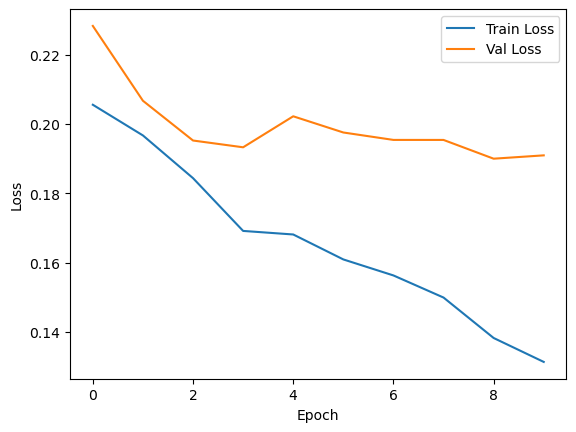

In [10]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# Evaluate the model
BATCH_SIZE_TEST = 2 # Currently onoy supports batch size 1

dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED)

test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False, # Is true in EBREC, but then it does not work
    batch_size=BATCH_SIZE_TEST,
)

    
    
model.eval()

test_loss = 0.0
pred_test = []
labels_test = []
with torch.no_grad():
    for (inputs, labels) in test_dataloader:
        his_input_title, pred_input_title = inputs

        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        outputs = model(pred_input_title, his_input_title) # in shape (1, candidate_size)
        loss = criterion(outputs, labels)                  # in shape (1, candidate_size)
        test_loss += loss.item()

        print(outputs.shape)



        for i in range(outputs.size(0)):
            pred_test.append(outputs[i].tolist())
            labels_test.append(labels[i].tolist())

        
print(pred_test)
print(labels_test)

from from_ebrec.evaluation import MetricEvaluator
from from_ebrec.evaluation import AucScore, MrrScore, NdcgScore
metrics = MetricEvaluator(
    labels = labels_test,
    predictions= pred_test,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
metrics.evaluate()
print(metrics)

test_loss /= len(test_dataloader)
print("Test loss:", test_loss)

torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([

AUC:   0%|                                              | 0/128 [00:00<?, ?it/s]


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [18]:
number_to_print = 20
print("Top %d predictions vs labels:" % number_to_print)
labels = dataset.df_test["labels"].to_list()
for i in range(number_to_print):
    print(f"Article {i}")
    for j in range(len(pred_test[i])):
        print(f"{pred_test[i][j]:.3f} vs {labels[i][j]:.3f}")
    print("")





Top 20 predictions vs labels:
Article 0
0.102 vs 0.000
0.122 vs 0.000
0.427 vs 0.000
0.284 vs 0.000
0.064 vs 1.000


IndexError: list index out of range

Confusion Matrix:
[[2776   99]
 [ 233   24]]


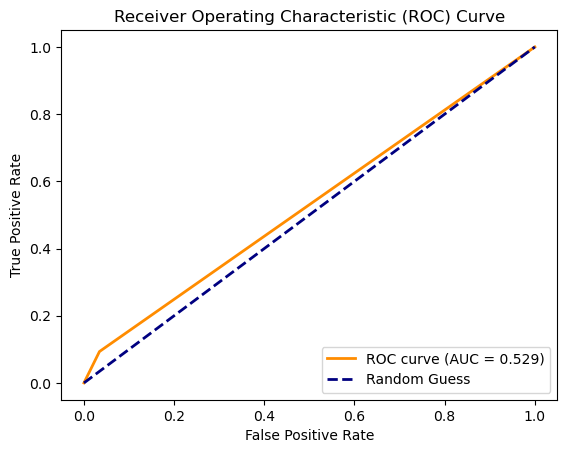

In [90]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Flatten the data for analysis
predicted_probabilities = [prob for article in pred_test for prob in article]
true_values = [val for article in labels[:len(pred_test)] for val in article]


# Set a threshold (commonly 0.5) to classify probabilities as 0 or 1
threshold = 0.5
predicted_classes = [1 if p >= threshold else 0 for p in predicted_probabilities]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_values, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate AUC and ROC curve
fpr, tpr, thresholds = roc_curve(true_values, predicted_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value explicitly highlighted
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()